## Learning Representations of Gene Ontology: Embedding GO Terms Attributes With Fine-Tunned Text Transformers

The [Gene Ontology (GO)](https://geneontology.org/docs/ontology-documentation/) is a directed knowledge graph where **each node represents a specific GO term**, defining a particular aspect of genes and their products. These GO terms are categoryzed into three primary ontologies:

- <font color="grey">***Molecular Function (MF)***</font>: These terms define the **activities** performed by gene products, such as *catalysis* or "*transport*", etc. These functions can be refined by more more specific GO terms, such as "protein kinase activity" within the broader category of "catalysis"


- <font color="grey">***Cellular Component (CC)***</font>: These terms specify the subcellular **location** of gene products, emcompasing compartments like *chloroplast* or *nucleus* , as well as macromolecular complexes like *proteasome* or *ribosome*


- <font color="grey">***Biological Process (BP)***</font>: These terms delineate the biological **pathways** in which gene products are involved, ranging from 'DNA repair' and 'carbohydrate metabolic process' to more overaching processes like *biosynthetic processes*

The GO graph integrates these these three aspects of gene annotation, presenting a **hierarchical** organization with **interconnections denoted by edges representing the relationships between terms**. Consequently, the GO graph can be visualized as three distinct but connected trees. However, bear in mind that the three GO ontologies are *'is a'* disjoint because there is no such relationship between terms from different trees, but other types of connections like *'part of'* and *'regulates'* exist. We also define terms as *parents* and *children* based on their position in the tree that we can loosely call *generations*: terms closer to the root are parents, while those closer to the terminal leaves are child terms. Please check the [Gene Ontology reference](https://geneontology.org/docs/ontology-documentation) for more information about how the GO graph is structured.

The GO graph empower us to classify genes and proteins based on their functions in associated processes ocurring in a specific subcellular compartment, being an essential tool to predict functions of newly discovered genes and their products. One feature often overlooked when deploying the GO graph to assist prediction and classification of gene function is the **textual definition of each GO term**. To harness the power of this valuable GO graph content, we will apply **Natural Language Processing** (**NLP**) tecniques to analyze and interpret these definitions.


>**Natural Language Processing (NLP)** is a burgeoning field in machine learning, focusing on techniques for extracting contextualized information from word sequences. It finds applications in diverse areas, including sentiment analysis and text generation for product reviews and chatbot interactions.


In this tutorial, we will use the text definitions of GO terms to fine-tune a pre-trained Large Language Model (LLMs) based on [transformer architecture](https://arxiv.org/abs/1706.03762): ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762). Fine-tunning is a powerful tecnique in machine learning that consists adapting models pre-trained on extensive data from different sources to specific applications. This task is done by keeping the deeper encoded features of the pre-trained model but adjusting the trainable parameters of the input and output layers. To demonstrate the power of this approach, we will conduct an analysis of Molecular Biology articles and try to accuratelly identify which primary ontology (BP, MF or CC) best characterizes the paper. This practical exercise will highlight the practicality of fine-tuning within a real-world context. We will also use the fine-tunned model to embed the text definitions into feature vectors to enrich nodes' features in the GO graph. By adding this additional attribute to the nodes, we aim to improve the power of GO graph in assisting machine learning applications such as prediction of gene functions and the outcome of metabolic pathways.


>**Text Embeddings**:  Machine learning algorithms primarily operate on numerical data. To utilize text data in these models, it must be transformed into numerical representations. Text embeddings are techniques that extract meaningful hidden features from text while preserving the sequential relationships between words. This ensures that the essential meaning of the text is preserved in the feature vector. 


In [1]:
# install required libraries

# !pip install obonet
# !pip install nltk
# !pip install transformers
# !pip install datasets
# !pip install wordcloud

In [2]:
# import libraries

import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import networkx as nx
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from wordcloud import WordCloud
from tqdm.notebook import tqdm_notebook


# progress bar for loops
tqdm_notebook.pandas()

# download / update punkt, the nltk's recommended sentences' tokenizer
import nltk

nltk.download("punkt")


# set home directory
from pathlib import Path

home_dir = Path("../GO-graph-definition-text-transformer/")
print(f"Home directory: {home_dir.as_posix()}")

Home directory: ../GO-graph-definition-text-transformer


[nltk_data] Downloading package punkt to /home/clever/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# custom functions


# plot confusion matrix
def plot_cm(y_true: pd.Series, y_pred: pd.Series):
    # print out the balanced accuracy score
    print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_pred, y_true):.1%}")

    cm = confusion_matrix(
        y_true,
        y_pred,
        normalize="pred",
    )

    # converting into dataframe for easy plotting
    cm_df = pd.DataFrame(
        cm,
        index=["Biological Process", "Cellular Component", "Molecular Function"],
        columns=["Biological Process", "Cellular Component", "Molecular Function"],
    )

    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)
    sns.heatmap(
        data=cm_df,
        annot=True,
        cmap="Blues",
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()


# plot graphs or sub-graphs
def plot_graph(
    G: nx.Graph(),
    plot_nodes=list,
    plot_all=False,
    num_nodes=100,
    iterations=100,
    figure_size=(8, 8),
    node_color="green",
    font_color="black",
):
    """
    Plot the full graph (plot_all=True) or a sub-graph with the
    nodes passed as parameter. The 'n_terms' parameter controls
    how many nodes will be plotted in the top-down list of nodes.

    G: nx.Graph
    plot_nodes: list with the nodes to plot
    plot_all: select wheter plot the full graph or a subgraph
    n_nodes: number of nodes to plot
    iterations: number of iterations of spring_layout algorithm
    figure_size: tuple with figure dimensions (W x H)
    node_color: specify node color
    """
    if plot_all:
        n_nodes = len(G.nodes)
        n_edges = len(G.edges)

    else:
        G = nx.subgraph(G, plot_nodes[:num_nodes])
        n_nodes = len(G.nodes)
        n_edges = len(G.edges)

    # set figure size
    rcParams["figure.figsize"] = figure_size

    # nodes features
    degree_dict = dict(G.degree)  # get degree to adjust node viz
    node_size = list([x * 100 for x in degree_dict.values()])
    node_alpha = [float(x / max(degree_dict.values())) for x in degree_dict.values()]

    pos = nx.spring_layout(
        G,
        scale=10,
        k=25 / np.sqrt(n_nodes),
        seed=13,
        iterations=iterations,
    )

    ax = nx.draw_networkx_nodes(
        G, pos, node_size=node_size, alpha=node_alpha, node_color=node_color
    )

    ax = nx.draw_networkx_edges(
        G, pos, width=0.5, node_size=node_size, edge_color="grey"
    )

    ax = nx.draw_networkx_labels(
        G,
        pos,
        font_size=10,
        font_color=font_color,
        horizontalalignment="center",
        verticalalignment="center",
    )

    plt.title(f"Graph plot with {G.order()} nodes and {G.size()} edges")
    plt.axis("off")
    plt.show()

## Reading and Parsing GO Graph Data

### File format

The GO graph is stored in the *OBO (Open Biomedical Ontologies) file oboformat*, which is specifically tailored for constructing and representing biological ontologies. We can use the Python library *obonet* to read and parse the *obo* file to convert it into a **NetworkX** object. [NetworkX](https://networkx.org/) provides a comprehensive framework to manipulate and analyze graphs. Below we load the GO graph and plot some nodes with high degree:

The GO graph is a MultiDiGraph named 'go' with 43248 nodes and 84805 edges.


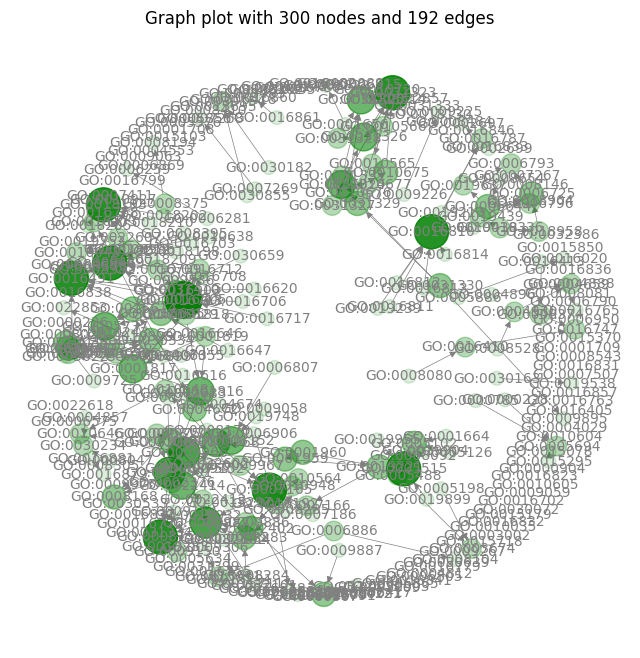

In [4]:
from obonet import read_obo

go_graph = read_obo(home_dir.joinpath("data/go-basic.obo"))
print(f"The GO graph is a {go_graph}.")

# select nodes with high degree
node_list = [n for n in go_graph.nodes() if go_graph.degree(n) > 20]

# plotting subgraph
plot_graph(
    G=go_graph,
    plot_nodes=node_list,
    plot_all=False,
    num_nodes=300,
    iterations=500,
    font_color="grey",
)

### Node attributes

The nodes include attributes that describe the corresponding GO terms. Let's display the attributes of a randomly chosen node to gain an insight into these attributes:

In [5]:
go_graph.nodes()[random.choice([x for x in go_graph.nodes()])]

{'name': 'stearoyl-[acp] desaturase activity',
 'namespace': 'molecular_function',
 'def': '"Catalysis of the reaction: O2 + a stearoyl-[acp] + a reduced ferredoxin = 2 H2O + an oleoyl-[acp] + an oxidized ferredoxin." [EC:1.14.19.2, GOC:pz]',
 'xref': ['EC:1.14.19.2', 'MetaCyc:RXN-7903', 'RHEA:11776'],
 'is_a': ['GO:0016717']}

All GO terms contain the following essential attributes:

>***name***: unique identifier of the term in a human-readable format

>***namespace***: one of the three major ontologies (MF, CC or BP) to which the term belongs

>***definition***: a short description of what the GO term means for humans. It can also contains references to publications defining the term (e.g. PMID:10873824).

There are additional attributes of each node corresponding to GO terms, but we won't be using them in this project.

### Creating a DataFrame with Node Attributes

Our next task involves extracting attributes from GO graph nodes and organizing them into a dataframe. This process aims to streamline the management of text definitions. Additionally, we will add a column with the word count for each GO term's definition and visualize the distribution of these counts. Later, this distribution will give valuable insights into selecting optimal hyperparameters for tokenization (i.e. break the text into individual words, or tokens) and fine-tuning our chosen pre-trained model.

  0%|          | 0/43248 [00:00<?, ?it/s]

,go_id,name,aspect,definition,def_word_count
0,GO:0000001,mitochondrion inheritance,biological_process,"The distribution of mitochondria, including th...",23
1,GO:0000002,mitochondrial genome maintenance,biological_process,The maintenance of the structure and integrity...,19
2,GO:0000003,reproduction,biological_process,The production of new individuals that contain...,19
3,GO:0000006,high-affinity zinc transmembrane transporter a...,molecular_function,Enables the transfer of zinc ions (Zn2+) from ...,44
4,GO:0000007,low-affinity zinc ion transmembrane transporte...,molecular_function,Enables the transfer of a solute or solutes fr...,50


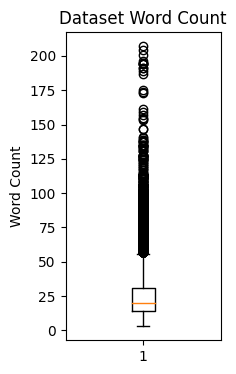

In [6]:
# create GO definitions dataframe

# creating empty dataframe to store nodes' attributes
go_df = pd.DataFrame(columns=["go_id", "name", "aspect", "definition", "def_word_count"])

# iterating over nodes to extract dictionary keys and values
for idx, item in tqdm_notebook(
    enumerate(go_graph.nodes.items()), total=len(go_graph.nodes)
):
    go_term = item[0]
    name = item[1]["name"]
    aspect = item[1]["namespace"]
    definition = item[1]["def"].split(sep='"', maxsplit=2)[1]
    def_word_count = len(re.findall(r"\w+", definition))
    go_df.loc[idx] = [
        go_term,
        name,
        aspect,
        definition,
        def_word_count,
    ]

# saving dataframe
home_dir.joinpath("data/").mkdir(parents=True, exist_ok=True)
go_df.to_csv(home_dir.joinpath("data/go_df.csv"), index=False)

display(go_df.head())

# word counts boxplot
plt.figure(figsize=(2, 4))
plt.title("Dataset Word Count")
plt.boxplot(go_df.def_word_count.values)
plt.ylabel("Word Count")
plt.show()

## Utilizing Pre-Trained Transformer Language Models (LLMs) for Text Classification and Embedding

**Transformers** have gained significant attention in the machine learning landscape, contributing to the development of generative models like [chatGPT](https://chat.openai.com). These transformer-based architectures are specifically engineered to analyze the relationships between words in sentences, considering their positions. This capability is instrumental in tasks such as text classification and ranking, as well as enabling generative models to generate new sentences in response to queries.

In this tutorial, we will explore the process of **fine-tuning**, which entails training a pre-existing **Large Language Model** (LLM), namely [bert-base-multilingual-uncased](https://huggingface.co/bert-base-multilingual-uncased). Our objective is to leverage this LLM to categorize GO term definitions based on their alignment with the major GO ontologies (BP, CC, and MF). Additionally, we will extract text embeddings from GO term definitions to serve as supplementary data for training models aimed at predicting protein annotations.

The chosen model is founded on the well-known [Bidirectional Encoder Representations from Transformers (BERT)](https://huggingface.co/docs/transformers/model_doc/bert) architecture, which has undergone pre-training on an extensive dataset comprising millions of entries from [Wikipedia](https://www.wikipedia.org/) in 102 different languages.

## Dataset Preparation

Our initial step involves pre-processing the dataset to make it compatible with the pre-trained model. To achieve this, we will carry out the following tasks:

1. **Dataset Splitting**: We will divide the data into three subsets: training, validation, and testing. These sets will contain the input text derived from GO terms' definitions.

2. **Tokenization**: The input text will undergo a process known as tokenization. This process breaks the text into smaller units, known as tokens, while also incorporating special tokens that signal the start and end of sequences and sentences. This step is crucial for the model to understand the text.

For creating and handling these datasets, we will utilize the [Dataset](https://huggingface.co/docs/datasets/index) library provided by Hugging Face. Furthermore, as our project progresses, we will leverage pre-trained sequence classification models and their corresponding tokenizers also available from [Hugging Face](https://huggingface.co/).

Before proceeding, we will make two essential modifications to our dataset: renaming the *definition* column to *text* and converting the *aspect* column to a categorical data type.

In [7]:
# loading saved dataframe with GO graph nodes' attributes

# loading GO dataframe
go_df = pd.read_csv(home_dir.joinpath("data/go_df.csv"))

# renaming definition column
go_df.rename(columns={"definition": "text"}, inplace=True)

# converting categorical labels to numbers (aspect)
go_df["aspect"] = pd.Categorical(go_df["aspect"])

# getting categorical codes
go_df["label"] = go_df["aspect"].cat.codes

# selecting only relevant columns
data = go_df[["text", "label"]].copy()

display(data.head())

# printing label mapping for reference
print("\nCode: label")
for code, aspect in enumerate(go_df.aspect.cat.categories):
    print(f"{code}: {aspect}")

,text,label
0,"The distribution of mitochondria, including th...",0
1,The maintenance of the structure and integrity...,0
2,The production of new individuals that contain...,0
3,Enables the transfer of zinc ions (Zn2+) from ...,2
4,Enables the transfer of a solute or solutes fr...,2



Code: label
0: biological_process
1: cellular_component
2: molecular_function


We can visualize the most common terms in the dataset by creating a word cloud. This visual representation provides an effective means of identifying the most frequently occurring words:

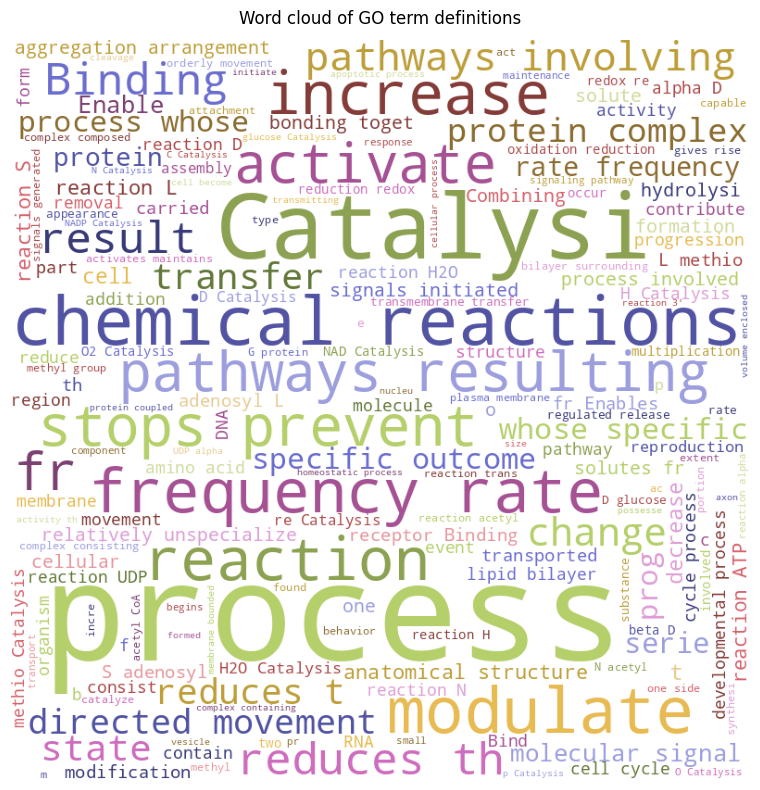

In [8]:
go_wordcloud = WordCloud(
    width=800,
    height=800,
    background_color="white",
    min_font_size=10,
    colormap="tab20b",
).generate(data.text.to_string())

plt.figure(figsize=(8, 8), facecolor=None)
plt.suptitle("Word cloud of GO term definitions")
plt.imshow(go_wordcloud)
plt.axis("off")
plt.tight_layout(pad=1)
plt.show()

The **tokenization strategy must align with the chosen model**. This is crucial to ensure that tokens are mapped to the **same indices** presented to the model during training and that the **same special tokens** are used to denote the beginning of a text sequence and the separation between sentences.

In this context, we are employing the [BertTokenizerFast](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizerFast) with the tokenization strategy of the pre-trained model [bert-base-multilingual-uncased](https://huggingface.co/bert-base-multilingual-uncased) to convert text to lowercase and eliminate capitalization. Lowercase inputs typically result in a smaller number of tokens and tend to generalize better for unseen text sequences in a **production phase**. However, we can later explore the possibility of using cased inputs to evaluate model performance.

As indicated by the boxplot above, all GO term definitions conform to the input size requirements for fine-tuning (510 tokens). Nonetheless, we might consider limiting the input length to expedite the fine-tuning process. To proceed, we will create the dataset with training and test sets using Hugging Face's Dataset library. We will employ stratification to maintain the distribution of labels between datasets.

In [9]:
from datasets import Dataset

# create dataset
dataset = Dataset.from_pandas(data)

# change label column to ClassLabe to allow stratification
dataset = dataset.class_encode_column("label")

dataset = dataset.train_test_split(test_size=0.3, stratify_by_column="label")
dataset

Stringifying the column:   0%|          | 0/43248 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/43248 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 30273
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12975
    })
})

In [10]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-multilingual-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, max_length=150, truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

tokenized_dataset

Map:   0%|          | 0/30273 [00:00<?, ? examples/s]

Map:   0%|          | 0/12975 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 30273
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12975
    })
})

Each feature holds specific information relevant to the dataset:

- **text**: the input text sequence
- **label**: numerical values corresponding to the ontologies to predict:
  - 0: biological_process
  - 1: cellular_component
  - 2: molecular_function
- **input_ids**: These are the indices of each token within the sequence. These indices were generated during the model's pre-training phase.
- **token_type_ids**: This feature provides references to the sentence to which each token belongs.
- **attention_mask**: It indicates whether the token should be attended to during processing.

We can decode the the **input_ids** to obtain the original text. Below we print out the decoded definitions based on the input_ids (I did some changes in the print for better visualization of the decoded input ids and the input ids):

In [11]:
dataset_len = len(tokenized_dataset["train"]["input_ids"])

for i in range(5):
    idx = random.randint(0, dataset_len)
    print(tokenizer.decode(tokenized_dataset["train"]["input_ids"][idx]))
    input_ids_list = tokenized_dataset["train"]["input_ids"][idx]
    print(input_ids_list)
    print(f"Input length: {len(input_ids_list)}")
    print(50 * "=")

[CLS] any process that activates or increases the frequency, rate or extent of receptor - mediated virion attachment to host cell. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[101, 11318, 14936, 10203, 45449, 11075, 10362, 50436, 10103, 32727, 117, 17593, 10362, 46777, 10108, 26643, 118, 11456, 11894, 27795, 10

**Classification Token [CLS]** and **Separator Token [SEP]** are special tokens that provide information about the input. [CLS] marks the initiation of the sequence for the BERT model we intend to employ, essentially signifying the beginning of the input sequence. [SEP], on the other hand, separates sentences in sentence-pair tasks. It aids the model in capturing the relationships between two sentences that are concatenated using [SEP]. Notably, the use of padding with [PAD] is crucial to ensure uniform sentence sizes during tokenization.

> **Truncation and Padding**: The truncation and padding parameters instruct the tokenizer on how to handle sequences of varying lengths. If the *truncation* parameter is set to 'True,' input sequences with more tokens than what the model can accept will be truncated. Conversely, if the sequences are shorter than what the model accepts, the special padding token [PAD] will be added until the number of tokens in the input matches the model's requirements. Truncation and padding are pivotal in guaranteeing consistent input sizes, as model inputs are predefined fixed-size tensors (e.g., 510 tokens + 2 special tokens [CLS] and [SEP] = 512).

Now, let's proceed by instantiating the model class [BertForSequenceClassification](https://huggingface.co/docs/transformers/v4.33.2/en/model_doc/bert#transformers.BertForSequenceClassification), loading it with the **weights** from the pre-trained model "bert-base-multilingual-cased." We will also define the number of target labels we aim to predict. In our case, we will predict whether the text pertains to Biological Process, Cellular Component, or Molecular Function. Consequently, the number of labels is set to **3**.

Now that the dataset is ready, we will instantiate the pre-trained model and fine-tune it. However, let's check if the GPU is available to expedite the training process. We can also check the CUDA memory summary to see the allocated memory and free-up some space for processing our data.

>Training and fine-tunning such Large Language Models can take a tool in the hardware. The model we will be fine-tuning have 168 millions of trainable parameters from an architecture with 12 attention layers. Training and fine-tuning times using only the CPU may not be timely appropriate.

In [24]:
import torch

print(f"cuda available?: {torch.cuda.is_available()}")
print(torch.cuda.memory_summary())

# free-up memory
torch.cuda.empty_cache()

cuda available?: True
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1939 MiB |   2906 MiB |  20081 GiB |  20079 GiB |
|       from large pool |   1938 MiB |   2892 MiB |  19663 GiB |  19661 GiB |
|       from small pool |      1 MiB |     24 MiB |    418 GiB |    418 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   1939 MiB |   2906 MiB |  20081 GiB |  20079 GiB |
|       from large pool |   1938 MiB |   2

In [25]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-uncased", num_labels=3)

model.cuda()
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

We will perform fine-tuning of the model using the [Trainer](https://huggingface.co/docs/transformers/v4.33.2/en/main_classes/trainer#transformers.Trainer) class, a specialized tool for optimizing the training of Hugging Face's models.

To configure the trainer effectively, we need to set the **hyperparameters** using the [TrainingArguments](https://huggingface.co/docs/transformers/v4.33.2/en/main_classes/trainer#transformers.TrainingArguments) and specify the evaluation metrics using the [evaluate](https://huggingface.co/docs/evaluate/index) module. This enables us to closely monitor the training progress and assess performance post fine-tuning.

In [26]:
# PyTorch Trainer
from transformers import TrainingArguments
import accelerate

train_args = TrainingArguments(output_dir="test_trainer")

# list training parameters
args_list = [
    x for x in list(dir(train_args)) if not re.compile(r"\b_[A-Za-z0-9_]*\b").match(x)
]
print(f"There are {len(args_list)} training arguments: {args_list}")

There are 140 training arguments: ['adafactor', 'adam_beta1', 'adam_beta2', 'adam_epsilon', 'auto_find_batch_size', 'bf16', 'bf16_full_eval', 'data_seed', 'dataloader_drop_last', 'dataloader_num_workers', 'dataloader_pin_memory', 'ddp_backend', 'ddp_broadcast_buffers', 'ddp_bucket_cap_mb', 'ddp_find_unused_parameters', 'ddp_timeout', 'ddp_timeout_delta', 'debug', 'deepspeed', 'deepspeed_plugin', 'default_optim', 'device', 'disable_tqdm', 'distributed_state', 'do_eval', 'do_predict', 'do_train', 'eval_accumulation_steps', 'eval_batch_size', 'eval_delay', 'eval_steps', 'evaluation_strategy', 'fp16', 'fp16_backend', 'fp16_full_eval', 'fp16_opt_level', 'framework', 'fsdp', 'fsdp_config', 'fsdp_min_num_params', 'fsdp_transformer_layer_cls_to_wrap', 'full_determinism', 'get_process_log_level', 'get_warmup_steps', 'gradient_accumulation_steps', 'gradient_checkpointing', 'greater_is_better', 'group_by_length', 'half_precision_backend', 'hub_model_id', 'hub_private_repo', 'hub_strategy', 'hub_t

Since the Trainer lacks an automatic performance evaluator during training, we must add metrics using *evaluate* and pass them to Trainer via TrainingArguments.

We'll use ROC/AUC score for performance assessment and create a function to convert predictions to logits, as explained in [this Hugging Face tutorial](https://huggingface.co/docs/transformers/training).

In [27]:
import evaluate

# list metrics
metrics_list = evaluate.list_evaluation_modules()
print(f"There are {len(metrics_list)} available metrics: {metrics_list}")

# load roc_auc metric
metric = evaluate.load("accuracy")


# convert preds --> logits
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


# set evaluation for training
train_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="epoch",
)

There are 140 available metrics: ['precision', 'code_eval', 'roc_auc', 'cuad', 'xnli', 'rouge', 'pearsonr', 'mse', 'super_glue', 'comet', 'cer', 'sacrebleu', 'mahalanobis', 'wer', 'competition_math', 'f1', 'recall', 'coval', 'mauve', 'xtreme_s', 'bleurt', 'ter', 'accuracy', 'exact_match', 'indic_glue', 'spearmanr', 'mae', 'squad', 'chrf', 'glue', 'perplexity', 'mean_iou', 'squad_v2', 'meteor', 'bleu', 'wiki_split', 'sari', 'frugalscore', 'google_bleu', 'bertscore', 'matthews_correlation', 'seqeval', 'trec_eval', 'rl_reliability', 'angelina-wang/directional_bias_amplification', 'cpllab/syntaxgym', 'kaggle/ai4code', 'codeparrot/apps_metric', 'mfumanelli/geometric_mean', 'poseval', 'brier_score', 'abidlabs/mean_iou', 'abidlabs/mean_iou2', 'giulio98/codebleu', 'mase', 'mape', 'smape', 'dvitel/codebleu', 'NCSOFT/harim_plus', 'JP-SystemsX/nDCG', 'Drunper/metrica_tesi', 'jpxkqx/peak_signal_to_noise_ratio', 'jpxkqx/signal_to_reconstruction_error', 'hpi-dhc/FairEval', 'nist_mt', 'lvwerra/accura

To reduce the training duration and make it more suitable for a tutorial, we will fine-tune the model using a smaller subset of the training data, reserving 20% of it for validation purposes.

In [29]:
small_train_dataset = tokenized_dataset["train"].shuffle(seed=42).select(range(2000))
small_eval_dataset = tokenized_dataset["test"].shuffle(seed=42).select(range(400))

print(small_train_dataset)
print(small_eval_dataset)

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2000
})
Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 400
})


Finally, we can initiate the model training process. The Trainer class, provided by Hugging Face, simplifies the training procedure to just a few lines of code. Given all the information we've covered so far, the parameters to be passed to the Trainer become quite self-explanatory.

In [30]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


trainer.train()

/home/clever/anaconda3/envs/torchgpu/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.09187640994787216, 'eval_accuracy': 0.98, 'eval_runtime': 3.1195, 'eval_samples_per_second': 128.225, 'eval_steps_per_second': 16.028, 'epoch': 1.0}
{'loss': 0.243, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.030069438740611076, 'eval_accuracy': 0.99, 'eval_runtime': 3.798, 'eval_samples_per_second': 105.318, 'eval_steps_per_second': 13.165, 'epoch': 2.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.022925274446606636, 'eval_accuracy': 0.995, 'eval_runtime': 3.8986, 'eval_samples_per_second': 102.6, 'eval_steps_per_second': 12.825, 'epoch': 3.0}
{'train_runtime': 202.4191, 'train_samples_per_second': 29.641, 'train_steps_per_second': 3.705, 'train_loss': 0.173144837697347, 'epoch': 3.0}


TrainOutput(global_step=750, training_loss=0.173144837697347, metrics={'train_runtime': 202.4191, 'train_samples_per_second': 29.641, 'train_steps_per_second': 3.705, 'train_loss': 0.173144837697347, 'epoch': 3.0})

In [48]:
sample = "Water is key for all reactions sustaining life!"

inputs = tokenizer(
    sample, max_length=150, truncation=True, padding=True, return_tensors="pt"
)

print(inputs)
model.eval()

with torch.no_grad():
    logits = model(**inputs).logits

probs = torch.nn.functional.softmax(logits, dim=1)

prediction = torch.argmax(probs, dim=1).item()

{'input_ids': tensor([[  101, 11917, 10127, 14758, 10139, 10367, 43690, 10877, 76839, 10287,
           106,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

## Fine-Tunning in Native PyTorch

In [18]:
# import torch

# del model
# del trainer
# torch.cuda.empty_cache()